# LatenSeer Tutorial

There are four parts in this notebook:
1. **Input Selection** We select the input population of traces according to our needs. To save running time and reuse the input traces, we can store the trace information in advance.
2. **L-Tree Construction** We build a L-Tree for the selective traces with prediction of sibling relationships.
3. **UC1: Service Placement** This part presents how LatenSeer predict end-to-end latency distribution under hyperthetical latency changes in internal services.
4. **UC2: Latency Slack Analysis** This part presents how LatenSeer can be used to infer the latency budget of specific microservices.

## Setup

In [1]:
import pandas as pd

from latenseer.tree import Tree
from latenseer.probdist import PMF, CDF
from latenseer.plotting import plot_cdfs

DATA_PATH = '../data/DSB/determinism/placement'

## Part 1: Input Selection

We select the traces collected from the scenario where all services run in the same site.

In [15]:
rps = 500
sample_rate = '0.1'
wrk_type = 'mix136'
sample=False
num_traces = 1000 # only need this parameter if sample is True
local_wrk_name = 'local'

In [16]:
local_trace_path = f"{DATA_PATH}/rps{rps}/s{sample_rate}/{wrk_type}/{local_wrk_name}.csv"

## Part2: L-Tree Construction

This part constructs the L-Tree: 
1. build the L-Tree from selective traces.
2. infer sibling relationships

In [17]:
%%time

localtree = Tree(trace_path=local_trace_path)
localtree.from_trace(num_traces, trace_type='dsb', sample=sample)

100%|██████████████████████████████████████████████████████████| 29731/29731 [05:03<00:00, 98.11it/s]


CPU times: user 4min 55s, sys: 7.43 s, total: 5min 2s
Wall time: 5min 3s


In [6]:
# localtree.root.print()

In [18]:
%%time

localtree.extract_dependency()

CPU times: user 4.35 ms, sys: 3.64 ms, total: 7.99 ms
Wall time: 6.63 ms


## Part3: Case Study - Service Placement

In this experiment, the user-service and media-service were moved from local site (Utah) to a remote site(Wisconsin). We use the average ping time measurement of 38.7 ms between the Wisconsin and Utah sites as the injected latency delta.

In [19]:
migrated_services = ['user_service', 'media_service']
inject_delay = 38700

Then, we inject the delay to L-Tree, which triggers the latency propagation process and changes original end-to-end latency distribution.

In [20]:
%%time

localtree.root.clean_node() # always clean the nodes before doing any perturbation
localtree.apply_trigger(migrated_services, inject_delay)
pred_e2e = localtree.get_prediction(localtree.root)

cur_depth:  4
cur_depth:  3
cur_depth:  2
cur_depth:  1
cur_depth:  0
CPU times: user 4.97 s, sys: 337 ms, total: 5.31 s
Wall time: 5.16 s


We collected the ground truth in the multi-site deployment.

In [21]:
remote_wrk_name = 'mig_user_media'
remote_trace_path = f"{DATA_PATH}/rps{rps}/s{sample_rate}/{wrk_type}/{remote_wrk_name}.csv"

df = pd.read_csv(remote_trace_path)
groundtruth_e2e = PMF(df[df['parentid'].isna()]['rt'].to_list())

At last, we compare the results.

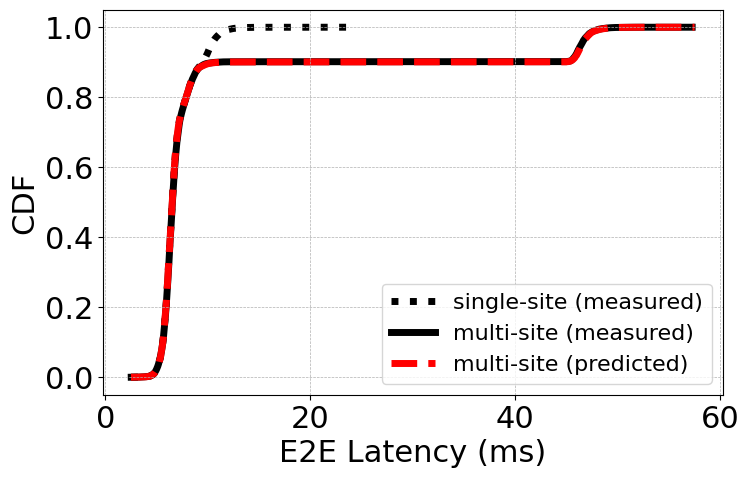

In [22]:
stats = {
    'single-measured': localtree.root.latency,
    'multi-pred': pred_e2e,
    'multi-measured': groundtruth_e2e,
}

plot_cdfs(stats)


## Part4: Case Study -Latency Slack Analysis

In this part, we use LatenSeer to infer the latency budget of specific microservices: it traverses the L-tree top-down, from the root node to all leaves, to compute the available latency slack for services. 

In [10]:
from latenseer.estimator import Estimator
from latenseer.plotting import plot_slacks

In [23]:
%%time

estimator = Estimator(localtree)
estimator.estimate('slack')

CPU times: user 9.07 s, sys: 102 ms, total: 9.17 s
Wall time: 9.16 s


In [24]:
%%time

slack_profile = estimator.get_slack_profile()
estimator.aggregate_slack()

CPU times: user 9.7 ms, sys: 485 µs, total: 10.2 ms
Wall time: 10.1 ms


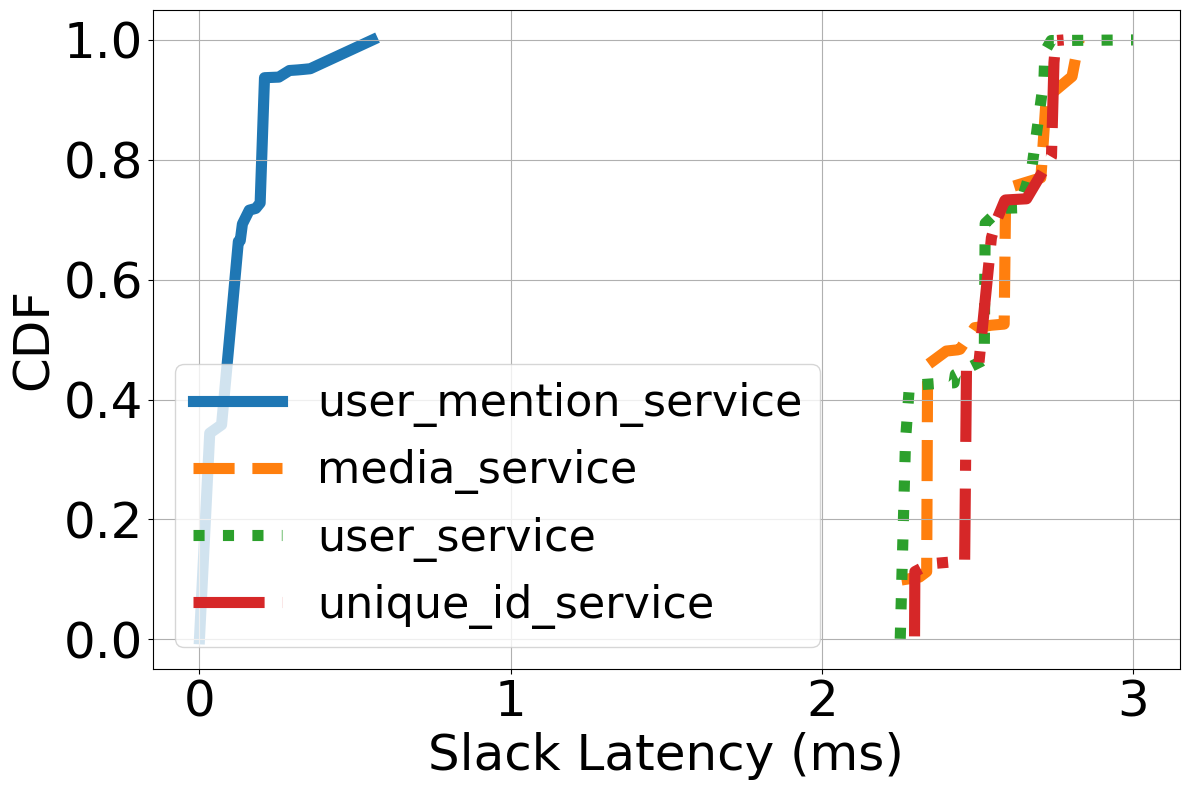

In [25]:
plot_slacks(estimator.agg_service_slack)